In [1]:
import numpy as np
import torch

# Batch size (before augmentation) and temperature
B = 4
tau = 0.25


def cos_pairwise(x):
    x = x / torch.linalg.vector_norm(x, dim=-1, keepdim=True)
    return x @ x.T

Best case:

$\log(\exp(1/\tau)+2B-2) - 1/\tau$

All embeddings are perpendicular (cos=0) except the
correct pairs which are parallel (cos=1)

In [2]:
projs = torch.eye(B, B).tile(2, 1) * torch.rand((2 * B, 1))
projs = torch.cat([projs, torch.zeros((2 * B, 2))], dim=1)
print("\nprojs")
print(projs.numpy().round(3))

cos = cos_pairwise(projs).fill_diagonal_(-torch.inf).div_(tau)
print("\ncos")
print(cos.numpy().round(3))

probs = cos.softmax(dim=-1)
print("\nprobs")
print(probs.mul(100).numpy().round(1))

print("\nLoss expected:", np.log(np.exp(1 / tau) + 2 * B - 2) - 1 / tau)
print(
    "Loss actual  :",
    torch.nn.functional.cross_entropy(cos, torch.arange(2 * B).roll(B)).item(),
)


projs
[[0.797 0.    0.    0.    0.    0.   ]
 [0.    0.25  0.    0.    0.    0.   ]
 [0.    0.    0.847 0.    0.    0.   ]
 [0.    0.    0.    0.723 0.    0.   ]
 [0.385 0.    0.    0.    0.    0.   ]
 [0.    0.144 0.    0.    0.    0.   ]
 [0.    0.    0.769 0.    0.    0.   ]
 [0.    0.    0.    0.641 0.    0.   ]]

cos
[[-inf   0.   0.   0.   4.   0.   0.   0.]
 [  0. -inf   0.   0.   0.   4.   0.   0.]
 [  0.   0. -inf   0.   0.   0.   4.   0.]
 [  0.   0.   0. -inf   0.   0.   0.   4.]
 [  4.   0.   0.   0. -inf   0.   0.   0.]
 [  0.   4.   0.   0.   0. -inf   0.   0.]
 [  0.   0.   4.   0.   0.   0. -inf   0.]
 [  0.   0.   0.   4.   0.   0.   0. -inf]]

probs
[[ 0.   1.7  1.7  1.7 90.1  1.7  1.7  1.7]
 [ 1.7  0.   1.7  1.7  1.7 90.1  1.7  1.7]
 [ 1.7  1.7  0.   1.7  1.7  1.7 90.1  1.7]
 [ 1.7  1.7  1.7  0.   1.7  1.7  1.7 90.1]
 [90.1  1.7  1.7  1.7  0.   1.7  1.7  1.7]
 [ 1.7 90.1  1.7  1.7  1.7  0.   1.7  1.7]
 [ 1.7  1.7 90.1  1.7  1.7  1.7  0.   1.7]
 [ 1.7  1.7  1.7 90.1 

Worst case:

$\log(2B-1)$

All embeddings are degenerate.

In [3]:
projs = torch.rand(5).repeat((2 * B, 1))
print("\nprojs")
print(projs.numpy().round(3))

cos = cos_pairwise(projs).fill_diagonal_(-torch.inf).div_(tau)
print("\ncos")
print(cos.numpy().round(3))

probs = cos.softmax(dim=-1)
print("\nprobs")
print(probs.mul(100).numpy().round(1))

print("\nLoss expected:", -np.log(1 / (2 * B - 1)))
print(
    "Loss actual  :",
    torch.nn.functional.cross_entropy(cos, torch.arange(2 * B).roll(B)).item(),
)


projs
[[0.138 0.709 0.912 0.403 0.689]
 [0.138 0.709 0.912 0.403 0.689]
 [0.138 0.709 0.912 0.403 0.689]
 [0.138 0.709 0.912 0.403 0.689]
 [0.138 0.709 0.912 0.403 0.689]
 [0.138 0.709 0.912 0.403 0.689]
 [0.138 0.709 0.912 0.403 0.689]
 [0.138 0.709 0.912 0.403 0.689]]

cos
[[-inf   4.   4.   4.   4.   4.   4.   4.]
 [  4. -inf   4.   4.   4.   4.   4.   4.]
 [  4.   4. -inf   4.   4.   4.   4.   4.]
 [  4.   4.   4. -inf   4.   4.   4.   4.]
 [  4.   4.   4.   4. -inf   4.   4.   4.]
 [  4.   4.   4.   4.   4. -inf   4.   4.]
 [  4.   4.   4.   4.   4.   4. -inf   4.]
 [  4.   4.   4.   4.   4.   4.   4. -inf]]

probs
[[ 0.  14.3 14.3 14.3 14.3 14.3 14.3 14.3]
 [14.3  0.  14.3 14.3 14.3 14.3 14.3 14.3]
 [14.3 14.3  0.  14.3 14.3 14.3 14.3 14.3]
 [14.3 14.3 14.3  0.  14.3 14.3 14.3 14.3]
 [14.3 14.3 14.3 14.3  0.  14.3 14.3 14.3]
 [14.3 14.3 14.3 14.3 14.3  0.  14.3 14.3]
 [14.3 14.3 14.3 14.3 14.3 14.3  0.  14.3]
 [14.3 14.3 14.3 14.3 14.3 14.3 14.3  0. ]]

Loss expected: 1.94591014

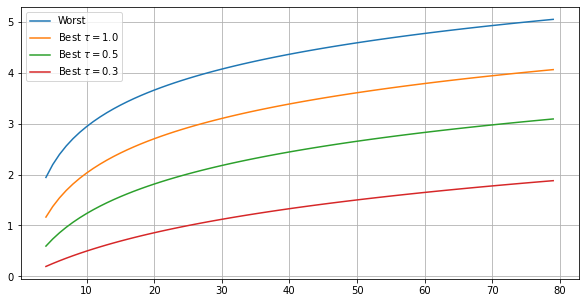

In [5]:
import matplotlib.pyplot as plt


def worst(B):
    return np.log(2 * B - 1)


def best(B, tau):
    return np.log(np.exp(1 / tau) + 2 * B - 2) - 1 / tau


B = np.arange(4, 80)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(B, worst(B), label="Worst")
for tau in [1.0, 0.5, 0.3]:
    ax.plot(B, best(B, tau), label=f"Best $\\tau={tau}$")
ax.legend()
ax.grid()